# Deep Learning Models (LSTM & GRU)

### Libraries

In [38]:
#Tensorflow
import tensorflow as tf
import keras
from keras.layers import LSTM, Dense, InputLayer, GRU, Normalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.losses import MeanAbsoluteError, MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam, SGD

#Data Manipulation
import numpy as np
import pandas as pd

#Functionalities
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

#Plots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

keras.utils.set_random_seed(812)
tf.config.experimental.enable_op_determinism()

parameters = {
    "dataset":{
        "path": "../data/data_casal_montserratina/LaMonserratina_2022_2023_2024.csv",
        "trainingSize": .70,
        "validationSize": .15,
        "testSize": .15
    },
    "backtesting":{
        "steps": 96,
        "fixedTrainSize": False,
        "refit": False,
    },
    "validation": {
        "n_splits" : 10
    },
    "lstm":{
        "epochs": 50,
        "batch_size": 64
    }
}

In [39]:
from tensorflow.python.client import device_lib
print("Keras backend:", keras.backend.backend())
print("TensorFlow version:", tf.__version__)
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

Keras backend: tensorflow
TensorFlow version: 2.16.1
GPUs Available: []


In [40]:
#Use GPU if possible
if len(tf.config.list_physical_devices('GPU')) != 0:
    tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

### Read and Split Dataset

In [41]:
#Read df
df = pd.read_csv(parameters['dataset']['path'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82269 entries, 0 to 82268
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               82269 non-null  int64  
 1   Date                     82269 non-null  object 
 2   Consumo_red [kW]         82269 non-null  float64
 3   pres [mb]                82269 non-null  float64
 4   slp [mb]                 82269 non-null  float64
 5   wind_dir [m/s]           82269 non-null  float64
 6   wind_gust_spd [m/s]      82269 non-null  float64
 7   wind_spd [m/s]           82269 non-null  float64
 8   temp [C]                 82269 non-null  float64
 9   app_temp [C]             82269 non-null  float64
 10  rh [%]                   82269 non-null  float64
 11  dewpt [C]                82269 non-null  float64
 12  clouds [%]               82269 non-null  float64
 13  vis [Km]                 82269 non-null  float64
 14  precip [mm]           

In [42]:
#Add N Lags
def addLags(df, lags):
    pass

In [43]:
#Drop Columns
dates = df["Date"]
df = df.drop("Date", axis = 1)

In [44]:
#Change Data Types
def parseData(df):
    for col in df:
        df[col] = df[col].astype(float)
    return df

#Normalize Data
def normalizeData(df):
    scaler = MinMaxScaler()
    df_normalized = scaler.fit_transform(df)
    return pd.DataFrame(df_normalized, columns=df.columns)

In [45]:
#Convert to float
df = parseData(df)

#Separate X and y
df = df.rename(columns={'Consumo_total [kW]': 'Demand'})
y = df["Demand"]
X = df.drop(columns=["Demand", "Minute",  "Consumo_red [kW]"], axis = 1)
X_columns = np.array(X.columns)

#Normalize Data
X = normalizeData(X)

#Convert df to np
X, y = X.to_numpy(), y.to_numpy()

#Split Dataset
trainingSize = int(parameters["dataset"]["trainingSize"] * X.shape[0])
validationSize = int(parameters["dataset"]["validationSize"] * X.shape[0]) + trainingSize

X_train, y_train = X[:trainingSize], y[:trainingSize]
X_val, y_val = X[trainingSize : validationSize], y[trainingSize : validationSize]
X_test, y_test = X[validationSize:], y[validationSize:]

X_train_dates = dates.loc[:trainingSize]
X_validation_dates = dates.loc[trainingSize:validationSize]
X_test_dates = dates.loc[validationSize:]    

#Reshape Datasets
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))
y_val = y_val.reshape((y_val.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

print(f"Training ==> X Shape: {X_train.shape}, y Shape: {y_train.shape}")
print(f"Validation ==> X Shape: {X_val.shape}, y Shape: {y_val.shape}")
print(f"Test ==> X Shape: {X_test.shape}, y Shape: {y_test.shape}")

Training ==> X Shape: (57588, 42, 1), y Shape: (57588, 1)
Validation ==> X Shape: (12340, 42, 1), y Shape: (12340, 1)
Test ==> X Shape: (12341, 42, 1), y Shape: (12341, 1)


### <b>Plots</b>

#### Predictions & Real Values

In [46]:
def plotPredictions(dates, y_pred, y_test):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    fig.show()

#### Plot Losses 

In [47]:
def plotLosses(train_loss, validation_loss):
    epochs_list = np.arange(0, 50)
    fig = go.Figure()
    trace1 = go.Scatter(x=epochs_list, y=train_loss, name="Training Loss", mode="lines")
    trace2 = go.Scatter(x=epochs_list, y=validation_loss, name="Validation Loss", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title = "Training and Validation Losses",
        xaxis_title = "Epoch",
        yaxis_title = "MSE Loss Value",
        width = 800,
        height = 400,
        margin = dict(l=40, r=30, t=50, b=30),
        legend = dict(
            orientation = "h",
            yanchor = "top",
            y = .98,
            xanchor = "right",
            x = .98
        ) 
    )
    fig.show()

#### Plot Metrics

In [48]:
def plotMetrics(train_rmse, validation_rmse, train_mae, validation_mae):
    epochs_list = np.arange(0, 50)
    fig = go.Figure()
    trace1 = go.Scatter(x=epochs_list, y=train_rmse, name="Training RMSE", mode="lines")
    trace2 = go.Scatter(x=epochs_list, y=validation_rmse, name="Validation RMSE", mode="lines")
    trace3 = go.Scatter(x=epochs_list, y=train_mae, name="Training MAE", mode="lines")
    trace4 = go.Scatter(x=epochs_list, y=validation_mae, name="Validation MAE", mode="lines")

    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.add_trace(trace3)
    fig.add_trace(trace4)
    fig.update_layout(
        title = "Metrics in Training/Validation",
        xaxis_title = "Epoch",
        yaxis_title = "RMSE / MAE",
        width = 800,
        height = 400,
        margin = dict(l=40, r=30, t=50, b=30),
        legend = dict(
            orientation = "h",
            yanchor = "top",
            y = .98,
            xanchor = "right",
            x = .98
        ) 
    )
    fig.show()

### Find Best Models

In [49]:
def selectModels(model_params, data, parameters):
    X_train, y_train = data["train"]["X"], data["train"]["y"]
    X_val, y_val = data["validation"]["X"], data["validation"]["y"]
    X_test, y_test = data["test"]["X"], data["test"]["y"]
    results = pd.DataFrame(columns=["Model", "nUnits", "nLayers", "dropout", "Loss_All", "MAE", "RMSE"])
    for param in tqdm(ParameterGrid(model_params), total=len(list(ParameterGrid(model_params)))):
        units = param.get('nUnits')
        layers = param.get("nLayers")
        dropout = param.get("dropout")
        days = param.get("days")
        #Build LSTM Model
        lstm_model = Sequential()
        for _ in range(layers - 1):
            lstm_model.add(LSTM(units=units, return_sequences=True, dropout=dropout))
        lstm_model.add(LSTM(units=units, dropout=dropout))
        lstm_model.add(Dense(1))

        #Compile LSTM Model
        lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
        lstm_model.fit(X_train, y_train, epochs = 40, batch_size = parameters["lstm"]["batch_size"], validation_data=(X_val, y_val), verbose=True)

        #Eval LSTM Model
        lstm_loss, lstm_mae, lstm_rmse = lstm_model.evaluate(
            x = X_test,
            y = y_test,
            batch_size = parameters["lstm"]["batch_size"],
            verbose=False
        )
        results.loc[len(results.index)] = ['LSTM', units, layers, dropout, lstm_loss, lstm_mae, lstm_rmse] 

        #Build GRU Model
        gru_model = Sequential()
        for _ in range(layers - 1):
            gru_model.add(GRU(units=units, return_sequences=True, dropout=dropout))
        gru_model.add(GRU(units=units, dropout=dropout))
        gru_model.add(Dense(1))

        #Compile GRU Model
        gru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
        gru_model.fit(X_train, y_train, epochs = 40, batch_size = parameters["lstm"]["batch_size"], validation_data=(X_val, y_val), verbose=True)

        #Eval GRU Model
        gru_loss, gru_mae, gru_rmse = gru_model.evaluate(
            x = X_test,
            y = y_test,
            batch_size = parameters["lstm"]["batch_size"],
            verbose=False
        )
        results.loc[len(results.index)] = ['GRU', units, layers, dropout, gru_loss, gru_mae, gru_rmse] 

    return results.sort_values(by=["RMSE", "MAE"])

data = {
    "train" : { "X" : X_train, "y" : y_train },
    "validation": { "X" : X_val, "y" : y_val },
    "test": { "X" : X_test, "y": y_test}
}

models_params = {
    'nUnits': [64, 128],     
    'nLayers': [1, 2],        
    'dropout': [0.0, 0.1]
}

results = selectModels(models_params, data, parameters)
results

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 93.5791 - mean_absolute_error: 6.1691 - root_mean_squared_error: 9.6322 - val_loss: 19.9748 - val_mean_absolute_error: 3.5516 - val_root_mean_squared_error: 4.4693
Epoch 2/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 64.5654 - mean_absolute_error: 5.1260 - root_mean_squared_error: 8.0339 - val_loss: 20.9899 - val_mean_absolute_error: 3.5269 - val_root_mean_squared_error: 4.5815
Epoch 3/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 61.1101 - mean_absolute_error: 5.0266 - root_mean_squared_error: 7.8166 - val_loss: 21.4866 - val_mean_absolute_error: 3.4421 - val_root_mean_squared_error: 4.6354
Epoch 4/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 60.4338 - mean_absolute_error: 5.0103 - root_mean_squared_error: 7.7733 - val_loss: 21.5636 - val_mean_absolute_error: 3.3849 - val_root_mean_squared_error: 4.6437
Epoch 5/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 59.9690 - mean_absolute_error: 4.9

 12%|█▎        | 1/8 [26:35<3:06:07, 1595.36s/it]

Epoch 1/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 47s 50ms/step - loss: 85.9849 - mean_absolute_error: 6.1292 - root_mean_squared_error: 9.2341 - val_loss: 27.2918 - val_mean_absolute_error: 4.4753 - val_root_mean_squared_error: 5.2242
Epoch 2/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - loss: 64.8634 - mean_absolute_error: 5.1781 - root_mean_squared_error: 8.0530 - val_loss: 21.1792 - val_mean_absolute_error: 3.5451 - val_root_mean_squared_error: 4.6021
Epoch 3/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - loss: 62.4891 - mean_absolute_error: 5.1279 - root_mean_squared_error: 7.9044 - val_loss: 21.9593 - val_mean_absolute_error: 3.6457 - val_root_mean_squared_error: 4.6861
Epoch 4/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 47s 52ms/step - loss: 59.5050 - mean_absolute_error: 4.9423 - root_mean_squared_error: 7.7126 - val_loss: 18.7697 - val_mean_absolute_error: 2.7587 - val_root_mean_squared_error: 4.3324
Epoch 5/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - loss: 54.3065 - mean_absolute_error: 4.6

 25%|██▌       | 2/8 [1:13:51<3:52:31, 2325.18s/it]

Epoch 1/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 37s 35ms/step - loss: 85.2616 - mean_absolute_error: 5.9010 - root_mean_squared_error: 9.1922 - val_loss: 22.7142 - val_mean_absolute_error: 3.8527 - val_root_mean_squared_error: 4.7659
Epoch 2/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - loss: 63.3248 - mean_absolute_error: 5.1371 - root_mean_squared_error: 7.9570 - val_loss: 21.4709 - val_mean_absolute_error: 3.6379 - val_root_mean_squared_error: 4.6337
Epoch 3/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - loss: 61.9637 - mean_absolute_error: 5.0635 - root_mean_squared_error: 7.8710 - val_loss: 20.3735 - val_mean_absolute_error: 3.1887 - val_root_mean_squared_error: 4.5137
Epoch 4/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - loss: 59.0565 - mean_absolute_error: 4.8813 - root_mean_squared_error: 7.6839 - val_loss: 19.8163 - val_mean_absolute_error: 3.1201 - val_root_mean_squared_error: 4.4515
Epoch 5/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - loss: 56.2954 - mean_absolute_error: 4.7

 38%|███▊      | 3/8 [2:11:24<3:56:40, 2840.02s/it]

Epoch 1/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 131s 142ms/step - loss: 79.7496 - mean_absolute_error: 5.8148 - root_mean_squared_error: 8.8909 - val_loss: 21.3493 - val_mean_absolute_error: 3.5348 - val_root_mean_squared_error: 4.6205
Epoch 2/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 136s 151ms/step - loss: 63.2767 - mean_absolute_error: 5.1582 - root_mean_squared_error: 7.9538 - val_loss: 19.3998 - val_mean_absolute_error: 3.0740 - val_root_mean_squared_error: 4.4045
Epoch 3/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 131s 146ms/step - loss: 56.2289 - mean_absolute_error: 4.7291 - root_mean_squared_error: 7.4972 - val_loss: 18.5134 - val_mean_absolute_error: 2.8302 - val_root_mean_squared_error: 4.3027
Epoch 4/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 133s 148ms/step - loss: 52.6305 - mean_absolute_error: 4.6211 - root_mean_squared_error: 7.2537 - val_loss: 18.0830 - val_mean_absolute_error: 2.7314 - val_root_mean_squared_error: 4.2524
Epoch 5/40
900/900 ━━━━━━━━━━━━━━━━━━━━ 135s 150ms/step - loss: 51.0861 - mean_absolute_

 38%|███▊      | 3/8 [3:22:43<5:37:52, 4054.60s/it]


KeyboardInterrupt: 

### <b>Train One Model</b>

#### Select Model

In [ ]:
#Choose Model
def get_LSTM_Model(num_features, n_units, n_layers, dropout):
    model = Sequential()
    model.add(InputLayer((num_features, 1)))
    for _ in range(n_layers - 1):
        model.add(LSTM(units=n_units, activation='tanh',kernel_initializer='glorot_normal', return_sequences=True, dropout=dropout))
    model.add(LSTM(n_units, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(1, activation='linear'))
    return model

def get_GRU_Model(num_features, n_units, n_layers, dropout):
    model = Sequential()
    model.add(InputLayer((num_features, 1)))
    for _ in range(n_layers - 1):
        model.add(GRU(units=n_units, kernel_initializer='glorot_normal', return_sequences=True, dropout=dropout))
    model.add(GRU(n_units, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(1, activation='linear'))
    return model

model = get_LSTM_Model(X_train.shape[1], 64, 1, 0.0)
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 42, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

#### Compile Model

In [ ]:
#Comp
cp = ModelCheckpoint('model.keras', save_best_only=True, monitor='val_root_mean_squared_error', mode='max', verbose=False)
model.compile(
    loss=MeanSquaredError(), 
    optimizer=Adam(learning_rate=0.0001), 
    metrics=[
        MeanAbsoluteError(),
        RootMeanSquaredError()
    ]
)

#### Train Model

In [ ]:
train_history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=parameters["lstm"]["epochs"],
    batch_size = parameters["lstm"]["batch_size"],
    callbacks=[cp]
)

Epoch 1/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - loss: 87.7981 - mean_absolute_error: 6.0677 - root_mean_squared_error: 9.3186 - val_loss: 23.9177 - val_mean_absolute_error: 4.0584 - val_root_mean_squared_error: 4.8906
Epoch 2/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - loss: 65.0624 - mean_absolute_error: 5.2677 - root_mean_squared_error: 8.0656 - val_loss: 23.7853 - val_mean_absolute_error: 4.0563 - val_root_mean_squared_error: 4.8770
Epoch 3/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - loss: 64.2931 - mean_absolute_error: 5.2176 - root_mean_squared_error: 8.0176 - val_loss: 20.7526 - val_mean_absolute_error: 3.6267 - val_root_mean_squared_error: 4.5555
Epoch 4/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - loss: 58.1266 - mean_absolute_error: 4.9389 - root_mean_squared_error: 7.6219 - val_loss: 17.8738 - val_mean_absolute_error: 2.7274 - val_root_mean_squared_error: 4.2277
Epoch 5/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - loss: 50.6827 - mean_absolute_error: 4.6

#### Evaluate Model 

In [ ]:
test_history = model.evaluate(
    x = X_test,
    y = y_test,
    batch_size = parameters["lstm"]["batch_size"],
)
predictions = model.predict(
    x = X_test,
    batch_size = parameters["lstm"]["batch_size"]
)

193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 22.8515 - mean_absolute_error: 3.3785 - root_mean_squared_error: 4.7262
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


In [ ]:
plotPredictions(X_test_dates, predictions.flatten(), y_test.flatten())

In [ ]:
plotLosses(train_history.history["loss"], train_history.history["val_loss"])

In [ ]:
plotMetrics(train_history.history["root_mean_squared_error"], train_history.history["val_root_mean_squared_error"], train_history.history["mean_absolute_error"], train_history.history["val_mean_absolute_error"])

100%|██████████| 24/24 [00:26<00:00,  1.12s/it]


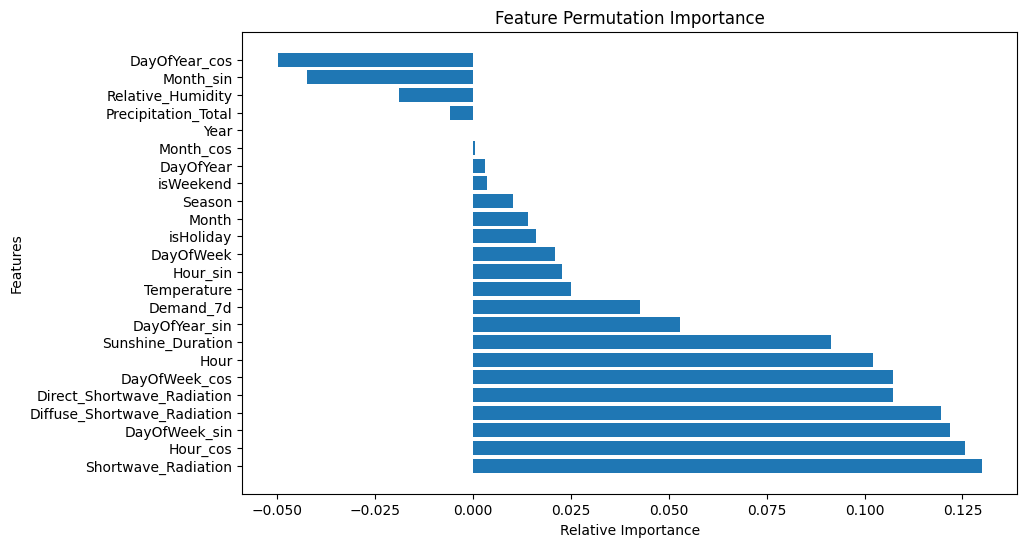

In [ ]:
from sklearn.utils import shuffle
def permutation_feature_importance(model, X_test, y_test, feature_names):
    y_pred = model.predict(X_test, verbose=False)
    #rmse_ref = root_mean_squared_error(y_test.flatten(), y_pred.flatten())
    mae_ref = mean_absolute_error(y_test.flatten(), y_pred.flatten())

    feature_importance = np.zeros(X_test.shape[1])

    for i in tqdm(range(X_test.shape[1]), total=(X_test.shape[1])):
        #Make a Copy of the Test Subset and Permute its values
        X_test_permuted = X_test.copy()
        X_test_permuted[:, i] = shuffle(X_test_permuted[:, i])

        #Calculate the metrics
        y_pred_permuted = model.predict(X_test_permuted, verbose=False)
        #rmse_permuted = root_mean_squared_error(y_test.flatten(), y_pred_permuted.flatten())
        mae_permuted = mean_absolute_error(y_test.flatten(), y_pred_permuted.flatten())

        #Calculate the difference in the metrics
        feature_importance[i] = mae_ref - mae_permuted
    
    #Normalize feature importances
    feature_importance /= feature_importance.sum()

    #Sort indexes
    sorted_indexes = feature_importance.argsort()[::-1]
    sorted_importances = feature_importance[sorted_indexes]
    sorted_importances_names = feature_names[sorted_indexes]

    #Bar Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_importances_names)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Feature Permutation Importance')
    plt.show()

permutation_feature_importance(model, X_test, y_test, X_columns)

In [ ]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)
scheduler_callback = LearningRateScheduler(scheduler)

model = get_GRU_Model(X_train.shape[1], 64, 1, 0.0)


model.compile(
    loss=MeanSquaredError(), 
    optimizer=Adam(learning_rate=0.0001), 
    metrics=[
        MeanAbsoluteError(),
        RootMeanSquaredError()
    ]
)
train_history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=parameters["lstm"]["epochs"],
    batch_size = parameters["lstm"]["batch_size"],
    callbacks=[scheduler_callback]
)
predictions = model.predict(
    x = X_test,
    batch_size = parameters["lstm"]["batch_size"]
)
test_history = model.evaluate(
    x = X_test,
    y = y_test,
    batch_size = parameters["lstm"]["batch_size"],
)
plotPredictions(X_test_dates, predictions.flatten(), y_test.flatten())
print("MAE: ", mean_absolute_error(y_true=y_test.flatten(), y_pred=predictions.flatten()), ", RMSE: ", root_mean_squared_error(y_true=y_test.flatten(), y_pred=predictions.flatten()))

Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 3442.2871 - mean_absolute_error: 40.3427 - root_mean_squared_error: 58.4429 - val_loss: 1796.6360 - val_mean_absolute_error: 34.4155 - val_root_mean_squared_error: 42.3867 - learning_rate: 1.0000e-04
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 2041.3651 - mean_absolute_error: 35.2700 - root_mean_squared_error: 45.1792 - val_loss: 1729.3331 - val_mean_absolute_error: 32.7733 - val_root_mean_squared_error: 41.5853 - learning_rate: 1.0000e-04
Epoch 3/50
341/767 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1989.8658 - mean_absolute_error: 34.4160 - root_mean_squared_error: 44.6052

KeyboardInterrupt: 

In [ ]:
plotMetrics(train_history.history["root_mean_squared_error"], train_history.history["val_root_mean_squared_error"], train_history.history["mean_absolute_error"], train_history.history["val_mean_absolute_error"])

100%|██████████| 22/22 [00:22<00:00,  1.04s/it]


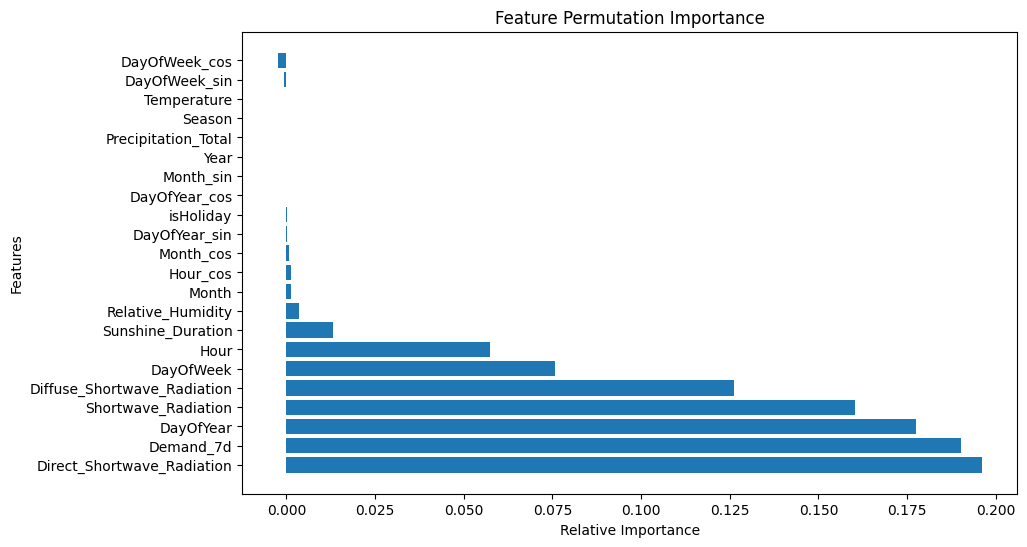

In [ ]:
permutation_feature_importance(model, X_test, y_test, X_columns)